# [Quora Questions pairs challenge](https://www.kaggle.com/c/quora-question-pairs/)

## Introduction

### Flow of solution

1. cleaning text

2. generating features

3. applying XGboost algorithm with parameter tuning

4. using magic features to boost the accuracy

5. adding some more parameteres to improve logloss





__what is data ??__



Given two files test and train data

- train data contains

    - __qid1,qid2__ : represents unique id for each question .

    - __question1,question2__ : two questions for which similarity to be predicted .

    - __is duplicate__ : tells whether question1 and question2 are similar .

- test data contains

    - __question1,question2__ : two questions for which similarity to be predicted.



__what is the question ??__



In train data, they gave question pairs(_question1,question2_) in each row of data and a column saying whether those two questions are similar or not and in test data they gave question pairs and asked to find whether those two questions are similar



__some quick points about strategy i followed: __



- Initially, i cleaned data by performing operations like

    - removing stop words

    - punctuations

    - generalized text by replacing words like _"what's"_ with _"what is"_ 

    - snowball stemming to reduce the number of words in dictionary so that computation will be reduced

- I strongly trust that good features are most crucial to a strong model. So i focused mostly on features rather than on algorithm for time being.

- In the given data, train data is 5 times more than test data.So the very basic problem about this kind of data is overfitting if we are not careful. I will explain about it in magic features.

- I have used Bag of words model to generate output.In bag of words model, we only consider each word in sentence as separate entity 

    - that means i have used features like number of words similar in both questions, cosine similarity between questions, number of words, number of nouns common in both, tf-idf ratios, first-word similarity etc.

    - All these features only consider each word as a saperate entity but never consider semantic relations between words.

- Then i used fuzzywuzzy library to generate similarity scores between questions .That helped me improve my log-loss .

- I used magic features to improve log-loss after reading [this blog](https://indatalabs.com/blog/data-science/how-to-win-kaggle-competition).

    - There are so many repeated questions in data

    - Magic features are based on relations between repeated questions and use this relation for prediction.

    - This improved log-loss in training model .__rest i explained clearly in the code implementation__

- Finally, i used XG-boost for predicting with logloss as metric and cost function of logistic regression



__Things I tried and did not work out__ :

- I tried to use vectorised sentences and planned to apply them to neural network so that relations between words can also be used for prediction. But when i started vectorizing the data i got memory error because test data is too huge for converting to vectors.

    - To solve this memory issue I should write a memory optimised code that may take a long time.So I thought it is not a good idea to stick to a single problem.




### Some ideas about what I can do if I get a supercomputer to work on with some more time

- using word embedding vectors and train CNN for semantic pattern recognition.

- currently, i did not use 2-grams, 3-grams which are computationally expensive but can be very significant in improving the model  

- using parts of speech to analyze semantic similarity between questions. Who knows, neural can find some useful patterns in them !!!

- lemmatization would definitely improve model but it will take a long time to compute.

- extracting vectors from word embeddings.

- generate document-to-vector feature.

- try grid search for parameter tuning .



_All these are possible if I have a good computational hardware resource to use and some more time ._



### conclusion :    



Most of the time i was generating features and using them to predict and they don't work very well. Then i try exploring again but at the end, my solution ended up being so naive. I used Bag of words model and never used semantic relations between words as features for prediction because it requires deep-learning(_i mean High computation_) . 

 

At the end i realize that i did not use stacking(ensembling) because i spent most of my time in generating useful features for prediction and understanding data I have studied about so many sentence similarity calculating algorithms like cosine similarity, fuzzywuzzy library, tf-idf for the importance of a sentence. Though I used sentence similarity algorithms common words served the best in prediction.



However, i did not use word embeddings with deep-learning for prediction which is used by all the top competitors.But i found some intersting blogs([one](https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning),[two](https://aclweb.org/anthology/K15-1013),[three](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)) about architecture of implementing deep learning and how to use word embeddings to CNN(convolutional neural nets). 





I really gained so much knowledge and experience because of this hackathon. I learned so much in such a short time. Thank you !!!



__Please have a look at what i did .__



In [47]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
stop_words = set(stopwords.words("english"))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import xgboost as xgb
import multiprocessing
import difflib

import gensim
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize,ngrams
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [48]:

temp_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in temp_stopwords]

def get_unigrams_intersection(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )




In [49]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
train = train.fillna('empty')
test = test.fillna('empty')

#print(train["question1"].loc[train["question1"].isnull() == True])
#print(test["question1"].loc[test["question1"].isnull() == True])




In [50]:

non_repeat_percent = (pd.concat([train.qid1,train.qid2],axis = 0).value_counts().size ) / (2*train.shape[0])
non_repeat_percent



0.6652811100942393

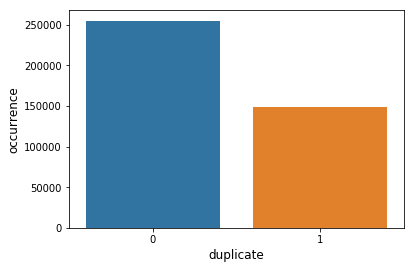

In [51]:
sns.countplot(train.is_duplicate)
plt.ylabel('occurrence', fontsize=12)
plt.xlabel('duplicate', fontsize=12)
plt.show()



In [52]:
all_questions = pd.DataFrame(pd.concat([train['question1'], train['question2']]))
all_questions.columns = ["questions"]
all_questions["is_duplicate"] = pd.DataFrame(pd.concat([train['is_duplicate'], train['is_duplicate']]))
all_questions["num_words"] = all_questions["questions"].apply(lambda x : len(str(x).split()))

all_questions.head()



,questions,is_duplicate,num_words
0,What is the step by step guide to invest in sh...,0,14
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,0,8
2,How can I increase the speed of my internet co...,0,14
3,Why am I mentally very lonely? How can I solve...,0,11
4,"Which one dissolve in water quikly sugar, salt...",0,13


### According to below graph number words is not showing any defenite pattern. It is just uniformly distributed 

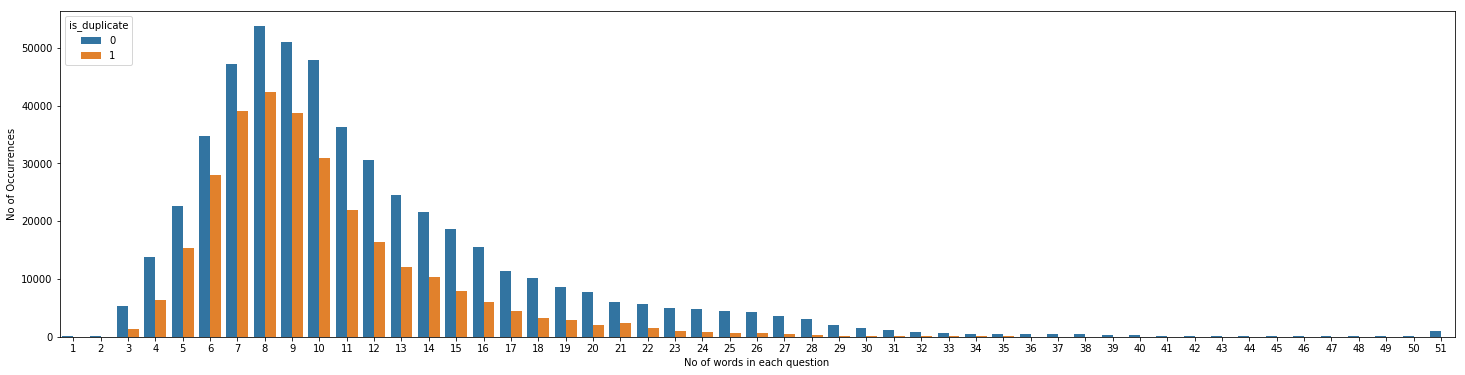

In [53]:
all_questions.loc[(all_questions["num_words"]>50),"num_words"] = 51
plt.figure(figsize=(25,6))
sns.countplot(data = all_questions,x = "num_words",hue = "is_duplicate")
plt.ylabel('No of Occurrences', fontsize=10)
plt.xlabel('No of words in each question', fontsize=10)
plt.show()



### below code generates words array and number of common words between questions .
__i did not use these features in prediction because i did not done with preprocessing yet . So ,dont worry about these features these are just for graph plotting __

In [54]:
train["unigrams_ques1"] = train['question1'].apply(lambda x: get_unigrams(str(x)))
train["unigrams_ques2"] = train['question2'].apply(lambda x: get_unigrams(str(x)))
train["unigrams_common_count"] = train.apply(lambda row: get_unigrams_intersection(row),axis=1)


### Below in the second graph We can clearly observe that most of the questions pairs are similar if more number of words matches between them

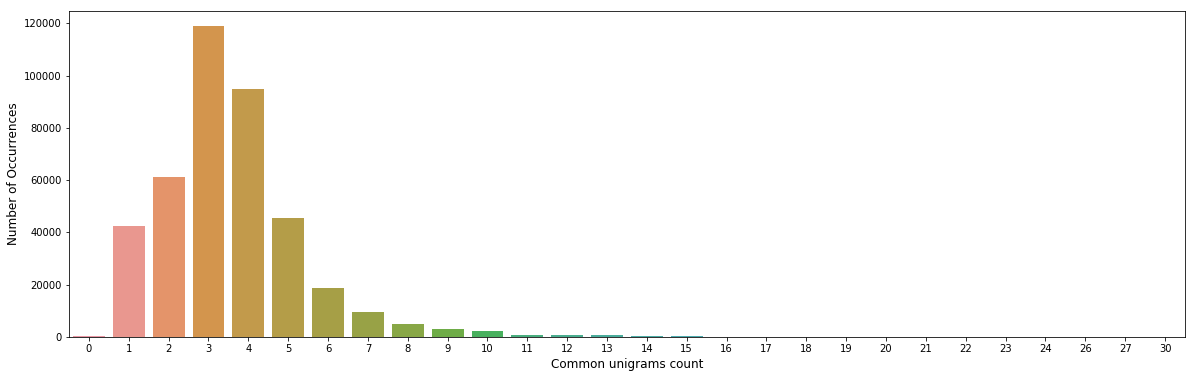

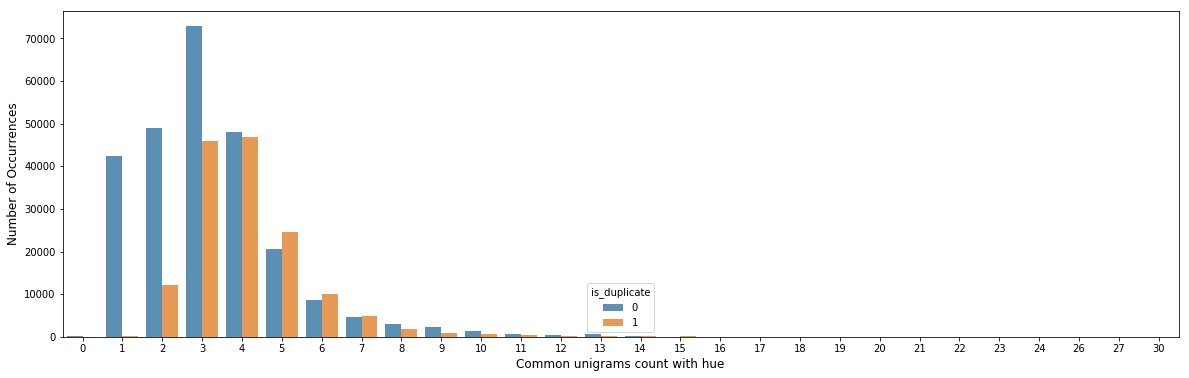

In [55]:
cnt_srs = train['unigrams_common_count'].value_counts()

plt.figure(figsize=(20,6))
sns.countplot(train['unigrams_common_count'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()
plt.figure(figsize=(20,6))
sns.countplot(data = train,x = "unigrams_common_count",hue = "is_duplicate", alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count with hue', fontsize=12)
plt.show()

## first word catagorising .

Below function takes first words of all questions and generates a feature which have different numbers for different startings of sentences

_most of the questions start with __why,when,what,who,where__ _

In [56]:
def firstwordfunc(list1,list2):
    #print(list1)
    q1_first_word = []
    for ques in list1:
        try:
            val = ques.split(" ")[0]
            q2_first_word.append(ques.split(" ")[0])
        except :
            q1_first_word.append("none")
    q2_first_word = []
    for ques in list2:
        try:
            #print(ques)
            val = ques.split(" ")[0]
            q2_first_word.append(ques.split(" ")[0])
        except :
            q2_first_word.append("none")
    comp = []
    temp = 0
    for q1,q2 in zip(q1_first_word,q2_first_word) :
        if q1 == q2 :
            temp += 1
            comp.append("same")
        else :
            comp.append(" ")
    temp
    all_first = q1_first_word + q2_first_word
    from collections import Counter
    import operator
    sorted_x = sorted(Counter(all_first).items(), key=operator.itemgetter(1),reverse= True)[:30]
    all_first = {}
    for i,val in enumerate(sorted_x) :
        all_first[val[0]] = i+1
    all_first

    q1_first_val_code = []
    q2_first_val_code = []
    for word in q1_first_word :
        if word in all_first.keys() :
            q1_first_val_code.append(all_first[word])
        else :
            q1_first_val_code.append(100)
    for word in q2_first_word :
        if word in all_first.keys() :
            q2_first_val_code.append(all_first[word])
        else :
            q2_first_val_code.append(100)
    return q1_first_val_code,q2_first_val_code

In [57]:
train["z_q1_start_word"],train["z_q2_start_word"] = firstwordfunc(train.question1.tolist(),train.question2.tolist())
test["z_q1_start_word"],test["z_q2_start_word"] = firstwordfunc(test.question1.tolist(),test.question2.tolist())

Filling empty places in test data with empty (_actually added this step after a long time from starting code_)

In [59]:
train = train.fillna('empty')
test = test.fillna('empty')

## Cleaning text
### performs three operations
1. generalization of some words(_gathered these from some dicussion in kaggle_). Thought these may reduce logloss
    - generalization improves the quality of vector when text is converted to vector 
2. Removing punctuations
3. handling stopwords
    - stopwords are removed using nltk
4. stemming(Snowball)
    - I chose this stemming because lancaster stemming is too aggressive and it generalizes dataset too much but generalization should be limited as we are comparing questions so i used snowball as it is imporved and faster version of porter stemming

In [60]:
def text_to_wordlist(text, remove_stop_words=True, stem_words=True):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

### process_question :
- processes the text using text_to_wordlist

In [61]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        question_list.append(text_to_wordlist(question))
        if len(question_list) % 100000 == 0:
            progress = len(question_list)/len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [62]:
train_question1 = []
train_question2 = []
test_question1 = []
test_question2 = []
process_questions(train_question1, train.question1, 'train_question1', train)
process_questions(train_question2, train.question2, 'train_question2', train)
process_questions(test_question1, test.question1, 'test_question1', test)
process_questions(test_question2, test.question2, 'test_question2', test)

train_question1 is 24.7% complete.
train_question1 is 49.5% complete.
train_question1 is 74.2% complete.
train_question1 is 98.9% complete.
train_question2 is 24.7% complete.
train_question2 is 49.5% complete.
train_question2 is 74.2% complete.
train_question2 is 98.9% complete.
test_question1 is 4.3% complete.
test_question1 is 8.5% complete.
test_question1 is 12.8% complete.
test_question1 is 17.1% complete.
test_question1 is 21.3% complete.
test_question1 is 25.6% complete.
test_question1 is 29.8% complete.
test_question1 is 34.1% complete.
test_question1 is 38.4% complete.
test_question1 is 42.6% complete.
test_question1 is 46.9% complete.
test_question1 is 51.2% complete.
test_question1 is 55.4% complete.
test_question1 is 59.7% complete.
test_question1 is 63.9% complete.
test_question1 is 68.2% complete.
test_question1 is 72.5% complete.
test_question1 is 76.7% complete.
test_question1 is 81.0% complete.
test_question1 is 85.3% complete.
test_question1 is 89.5% complete.
test_que

In [63]:
train.question1 = train_question1
train.question2= train_question2
test.question1 = test_question1
test.question2 = test_question2

### Storing dataframes and loading them into csv files to save time 

In [64]:
train.to_csv("train_pre_processed.csv",index = False)
test.to_csv("test_pre_processed.csv",index = False)

In [66]:
train = pd.read_csv("train_pre_processed.csv",encoding="ISO-8859-1")
test = pd.read_csv("test_pre_processed.csv",encoding="ISO-8859-1")

In [73]:
train.shape


(404290, 11)

In [74]:
train.columns


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'unigrams_ques1', 'unigrams_ques2', 'unigrams_common_count',
       'z_q1_start_word', 'z_q2_start_word'],
      dtype='object')

# generating features

### Tf-Idf(Text frequency - Inverse document frequency )
- I added this feature because if question1 and question2 have nearly equal importance it may represent similarity between questions . 
- however this turns out to be third best feature in prediction.
- I have mistaken and added only training questions to vectorize data after sometime i figure out that complete data is required to be vectorized(train and text questions) 

In [69]:
tfidf = TfidfVectorizer(stop_words='english',max_features = 20000, ngram_range=(1, 1))
#cvect = CountVectorizer(stop_words='english', ngram_range=(1, 1))

tfidf_txt = pd.Series(train['question1'].tolist() + train['question2'].tolist() + test['question1'].tolist() + test['question2'].tolist()).astype(str)
vector = tfidf.fit_transform(tfidf_txt)

### get_features()

__used to add features__ :
- calculating common nouns in questions .This feature is not too significant more over just resebles z_word_match feature. Still did not reduced the accuracy so added it .
- However as the length of original vector is large i should sum tf-idf vector to avoid memory error
- word length and character length 
- count of word matchings between questions. This is the most significant feature among all features because as i am using Bag of words model more matching means more similarity
- tfidf vector sum and mean .
    - Although sum and mean of vectors are similar features thought it would be great to experiment. 
        

In [70]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def get_features(df_features):
    
    print('nouns...')
    df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    print('lengths...')
    df_features['z_len1'] = df_features.question1.map(lambda x: len(str(x)))
    df_features['z_len2'] = df_features.question2.map(lambda x: len(str(x)))
    df_features['z_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    df_features['z_word_len2'] = df_features.question2.map(lambda x: len(str(x).split()))
    print('difflib...')
    df_features['z_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    print('tfidf...')
    df_features['z_tfidf_sum1'] = df_features.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_sum2'] = df_features.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_mean1'] = df_features.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_mean2'] = df_features.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    #df_features['z_tfidf_len1'] = df_features.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
    #df_features['z_tfidf_len2'] = df_features.question2.map(lambda x: len(tfidf.transform([str(x)]).data))
    return df_features.fillna(0.0)





In [124]:
#test = get_features(test)
#train = get_features(train)
#train.to_csv("train_pre_processed.csv",index = False)
#test.to_csv("test_pre_processed.csv",index = False)

In [76]:
train.shape

(404290, 11)

### cosine similarity
I considered cosine similarity is an extension to tf-idf. However i used same vector from tf_idf to calculate cosine similarity. tf-idf gives a feature based on magnitude similarity and _cosine similarity gives angular similarity between question pairs_

__cosine similarity for train data question pairs__

In [ ]:
a= []
for i in range(len(train['question1'])) :
    if i%100000 == 0 :
        print(str((i/len(train['question1']))*100),"% percent")
    a.append(cosine_similarity(vector[i],vector[len(train['question2'])+i]))
    
train["z_cs"] = a    
train["z_cs"] = [val[0][0] for val in train["z_cs"] ]

In [ ]:
test.shape

__cosine similarity for test data question pairs__

In [ ]:
a= []
for i in range(len(test['question1'])) :
    if i%100000 == 0 :
        print(str((i/len(test['question1']))*100),"% percent")
    a.append(cosine_similarity(vector[2*len(train['question2']) + i],vector[2*len(train['question2']) + len(test['question2']) + i]))


In [ ]:
test["z_cs"] = a    
test["z_cs"] = [val[0][0] for val in test["z_cs"] ]

In [ ]:
train.to_csv("train_pre_processed.csv",index = False)
test.to_csv("test_pre_processed.csv",index = False)

In [ ]:
train = pd.read_csv("train_pre_processed.csv")
test = pd.read_csv("test_pre_processed.csv")

In [93]:
train.shape

(404290, 24)

# prediction

### Prediction using XG-boost
Xg-boost is a great algorithm it uses decision trees and currently in this algorithm i used logistic regression cost-function and tuned some parameters however grid search on this big data is really time consuming (_it may take dats with my computation power_) 
- parameter tuning
    - __ETA(Learning rate)__ : i adjusted learning rate to get best result
    - __subsample(over fitting control)__ : read in article that if its value is 1 that may over fit the model.So reduced it to 0.7
    - __max depth of tree__ : large values may over fit hte model. However works well if we have more no of features.
    - __eval_matric__ : used logloss as evaluation metric as mentioned by kaggle
    - __objective(cost function)__ : used logistic regression cost function for gradient descent 

### Below function implements xgboost and saves data to submit.csv file

In [151]:
def predict_func(d_frame,skip_list = []) :
    col = [c for c in d_frame.columns if c[:1]=='z' and c not in skip_list]
    print("1",d_frame.shape)
    pos_train = d_frame[d_frame['is_duplicate'] == 1]
    neg_train = d_frame[d_frame['is_duplicate'] == 0]
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    temp_train = pd.concat([pos_train, neg_train])
    x_train, x_valid, y_train, y_valid = train_test_split(d_frame[col], d_frame['is_duplicate'], test_size=0.2, random_state=0)

    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'logloss'
    params["eta"] = 0.05
    params["subsample"] = 0.7
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = 4
    params["silent"] = 1
    params["seed"] = 1632

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s
    print(log_loss(d_frame.is_duplicate, bst.predict(xgb.DMatrix(d_frame[col]))))

    #test.to_csv('test.csv', index=False)

    sub = pd.DataFrame()
    sub["test_id"] = pd.to_numeric(test['test_id'], downcast='signed')
    sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[col]),ntree_limit=bst.best_ntree_limit)
    xgb.plot_importance(bst)
    print(sub.shape)
    sub.to_csv("submit.csv",index = False)

#### This gave a log loss of .356. Let's try to improve

[0]	train-logloss:0.683815	valid-logloss:0.683833
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.423241	valid-logloss:0.423886
[200]	train-logloss:0.397335	valid-logloss:0.398223
[300]	train-logloss:0.390751	valid-logloss:0.391885
[400]	train-logloss:0.387734	valid-logloss:0.389052
[499]	train-logloss:0.385524	valid-logloss:0.387077
0.385835015318


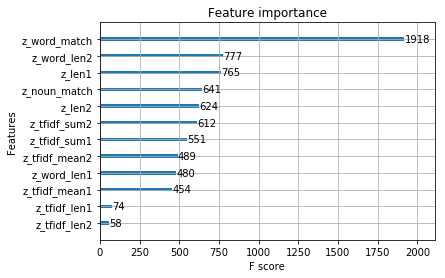

In [94]:
predict_func(train,test,["z_cs"])

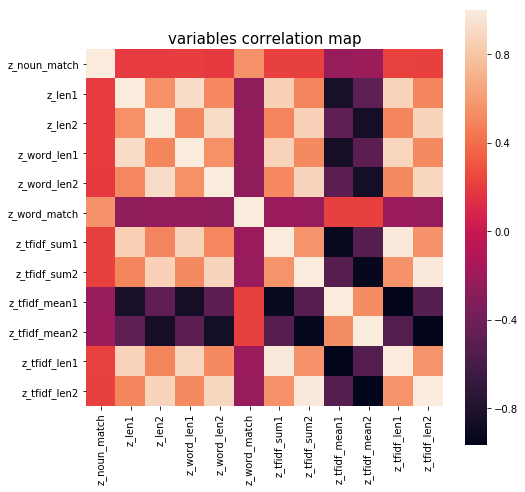

In [81]:
cols_to_use = [c for c in train.columns if c[:1]=='z' ]
temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("variables correlation map", fontsize=15)
plt.show()

### Added cosine similarity feature and tuned some parameters
Here i introduced cosine similarity feature to data .Surprisingly it did not improve the model accuracy significantly .356 has become 0.354

[0]	train-logloss:0.687997	valid-logloss:0.688
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.447539	valid-logloss:0.448015
[200]	train-logloss:0.388836	valid-logloss:0.389631
[300]	train-logloss:0.370076	valid-logloss:0.371119
[400]	train-logloss:0.362917	valid-logloss:0.364222
[499]	train-logloss:0.359595	valid-logloss:0.361154
0.359906755684


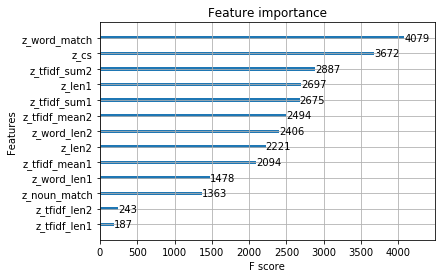

In [82]:
predict_func(train,test)

In [ ]:
#magic_test = pd.read_csv("processed_test.csv",encoding = "ISO-8859-1")
#magic_train = pd.read_csv("processed_train.csv",encoding = "ISO-8859-1")

In [ ]:
#magic_test.columns
#train = pd.concat([train,magic_train[['q1_q2_intersect', 'q1_freq', 'q2_freq']]],axis = 1)
#test = pd.concat([test,magic_test[['q1_q2_intersect', 'q1_freq', 'q2_freq']]],axis = 1)

## Added magic features 
there are so many repeated questions in data so 
- adding magic features had drastically improved the logloss. It shifted logloss from .364 to .216 .
- But i found that magic features are overfitting with train data because there are very less repetiton of questions in test data .

### reason :
Magic features boosted performance of my submission . This is because magic features are dependant on repeated questions and their relations .Like this they form a graph by chaining repeated questions
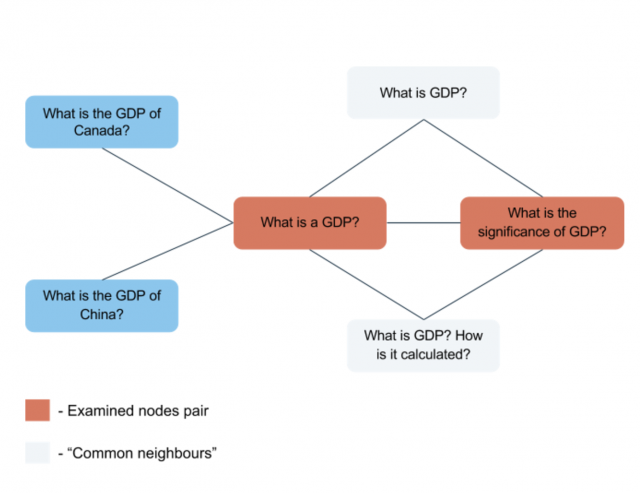
According to analysis repeated questions are more in train data and less in test data .It means that as the time went they tried to reduce repeated qustions.
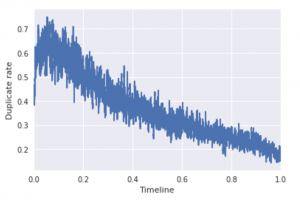
This left more repeated questions in train data and less repeated questions in test data .But still magic features helped a lot !!!



The below chunk of code  generates a dictionary set(q_dict) i which each question consists of its related chain of question .This dictionary set consists of questions ans keys of dictionary . 

__for example__ : if q1 and q2 are pairs of questions and q2 and q3 are pairs of question then in dictionary q2 question keyword will have a set of q1 and q3

In [85]:
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from collections import defaultdict
ques = pd.concat([train[['question1', 'question2']],test[['question1', 'question2']]], axis=0).reset_index(drop='index')
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])
print(0)
def q1_freq(row):
    return(len(q_dict[row['question1']]))
    
def q2_freq(row):
    return(len(q_dict[row['question2']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

train['z_q1_q2_intersect'] = train.apply(q1_q2_intersect, axis=1, raw=True)
print(1)
train['z_q1_freq'] = train.apply(q1_freq, axis=1, raw=True)
print(2)
train['z_q2_freq'] = train.apply(q2_freq, axis=1, raw=True)
print(3)
test['z_q1_q2_intersect'] = test.apply(q1_q2_intersect, axis=1, raw=True)
print(4)
test['z_q1_freq'] = test.apply(q1_freq, axis=1, raw=True)
print(5)
test['z_q2_freq'] = test.apply(q2_freq, axis=1, raw=True)
q_dict

KeyboardInterrupt: 

#### If you feel the above code cell is gonna take a long time you can run the below code cell it will take less time if your folder consists of appropriate files

In [119]:
train = pd.read_csv("train_pre_processed.csv")
test = pd.read_csv("test_pre_processed.csv")

## Here we can observe that log loss improved to  0.2124 because of magic features

[0]	train-logloss:0.686099	valid-logloss:0.686119
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.346481	valid-logloss:0.347096
[200]	train-logloss:0.2585	valid-logloss:0.25943
[300]	train-logloss:0.228627	valid-logloss:0.229749
[400]	train-logloss:0.217174	valid-logloss:0.218503
[499]	train-logloss:0.212117	valid-logloss:0.213619
0.212417379445


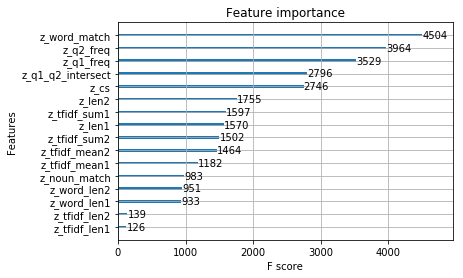

In [89]:
predict_func(train,test)

In [123]:
data = pd.concat([train,test],axis = 0)
data['z_fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
print(-3)
data['z_fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
# avoided below threeecause these take really long time to run !!!
#data['fuzz_partial_ratio'] = train.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
print(-2)
#data['fuzz_partial_token_set_ratio'] = train.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
#data['fuzz_partial_token_sort_ratio'] = train.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print(-1)
data['z_fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['z_fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print(1)




-3
-2
-1
1


In [129]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]
train.to_csv("train_pre_processed.csv",index = False)
test.to_csv("test_pre_processed.csv",index = False)

In [127]:
train.head()

,id,is_duplicate,qid1,qid2,question1,question1_nouns,question2,question2_nouns,test_id,z_cs,...,z_tfidf_mean2,z_tfidf_sum1,z_tfidf_sum2,z_word_len1,z_word_len2,z_word_match,z_fuzz_qratio,z_fuzz_WRatio,z_fuzz_token_set_ratio,z_fuzz_token_sort_ratio
0,0.0,0.0,1.0,2.0,What step step guide invest share market India,"['step', 'share', 'market', 'india']",What step step guide invest share market,"['step', 'share', 'market']",NaN,0.981808,...,0.417370,2.238763,2.086851,8,7,0.909091,93,95,100,93
1,1.0,0.0,3.0,4.0,What story Kohinoor Koh Noor Diamond,"['story', 'kohinoor', 'koh', 'diamond']",What would happen Indian government stole Kohi...,"['government', 'koh', 'diamond']",NaN,0.725853,...,0.363454,1.967700,2.544178,6,11,0.533333,63,86,91,63
2,2.0,0.0,5.0,6.0,How I increase speed internet connection using...,"['speed', 'connection', 'vpn']",How Internet speed increased hacking DNS,"['speed', 'dns']",NaN,0.273796,...,0.440665,2.420803,2.203327,8,6,0.363636,47,64,67,67
3,3.0,0.0,7.0,8.0,Why I mentally lonely How I solve,['i'],find remainder math 23 24 math divided 24 23,"['remainder', 'math', 'math']",NaN,0.000000,...,0.433376,1.722880,2.166878,7,9,0.000000,18,27,28,26
4,4.0,0.0,9.0,10.0,Which one dissolve water quickly sugar salt me...,"['dissolve', 'water', 'methane', 'carbon', 'di']",Which fish would survive salt water,"['fish', 'salt', 'water']",NaN,0.267193,...,0.496438,2.962017,1.985752,11,6,0.266667,33,86,63,47


In [ ]:
#data.to_csv("final_all_data.csv",index = True)

### after adding fuzzy similarity accuracy improved from .236 to .227 when submitted in kaggle. I feel that is significant !!!

__But here in below code output it is showing that log-loss have increased but thats not the case in final submission__

1 (404290, 29)
[0]	train-logloss:0.675041	valid-logloss:0.674992
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.30285	valid-logloss:0.301091
[200]	train-logloss:0.288371	valid-logloss:0.286995
[300]	train-logloss:0.283127	valid-logloss:0.282294
[400]	train-logloss:0.280259	valid-logloss:0.280089
[499]	train-logloss:0.27816	valid-logloss:0.278758
0.27827958456
(2345796, 2)


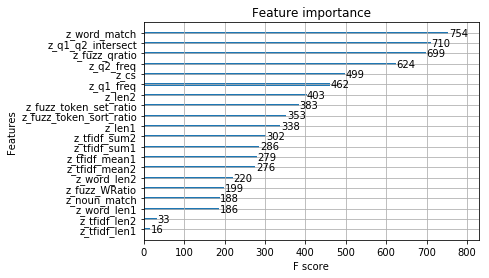

In [152]:
predict_func(train,[])


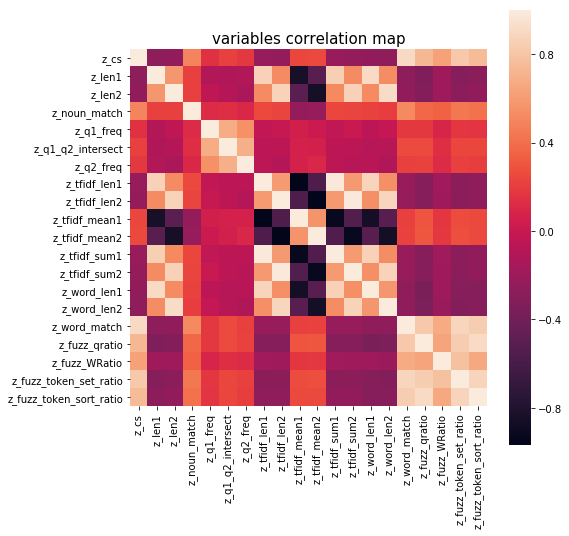

In [154]:
cols_to_use = [c for c in train.columns if c[:1]=='z' ]
temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("variables correlation map", fontsize=15)
plt.show()

## Thankyou for reading till the end !!!!